In [3]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
GPU = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [15]:
dataset_name = 'ManySig'
dataset_path='../../orbit_rf_dataset/data/compact_pkl_datasets/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 0

capture_date_list = compact_dataset['capture_date_list']
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)

6 12


In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
 

/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samer/miniconda3/en

In [7]:
 def create_net():

    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)
    x = Conv2D(8,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(32,(3,1),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,1),activation='relu',padding = 'same')(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_tx, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))
    
    return classifier

classifier = create_net()
classifier.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 2)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 2, 8)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 2, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 2, 16)         0         
_________

In [7]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx) 
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [28]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))

sig_len_list = [5, 10, 25, 50, 100, 400, 800]
print(sig_len_list)

patience = 5
n_epochs = 100


   



smTest_results_real = []
dfTest_results_real = []
dfTestBal_results_real = []

for sig_len in sig_len_list:
    print("");print("")
    print("sig_len: {}  ".format(sig_len))
    fname_w = 'weights/d004_{:04d}.hd5'.format(sig_len)
    rx_train_list= rx_list

    dataset = merge_compact_dataset(compact_dataset,capture_date_list,tx_list,rx_train_list, max_sig = sig_len+200,equalized=equalized)
    
    val_frac = 100/(sig_len+200)
    test_frac = 100/(sig_len+200)

    train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_list,
                                                        val_frac=val_frac, test_frac=test_frac)
    [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
    [sig_valid,txidNum_valid,txid_valid,_] = val_augset
    [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx

    if continue_training:
        skip = os.path.isfile(fname_w)
    else:
        skip = False
    classifier = create_net()
    if TRAIN and not skip:
        filepath = 't_weights_'+GPU
        c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
        history = classifier.fit(sig_train,txid_train,class_weight=cls_weights,
                                 validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
        classifier.load_weights(filepath)
        classifier.save_weights(fname_w,save_format="h5")
    else:
        classifier.load_weights(fname_w)

    smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]


    print(smTest_r)
    smTest_results_real.append(smTest_r)
    K.clear_session()
    
    
    


[5, 10, 25, 50, 100, 400, 800]


sig_len: 5  
0.73465276


sig_len: 10  
0.8551736


sig_len: 25  
0.9304861


sig_len: 50  
0.9542014


sig_len: 100  
0.9757639


sig_len: 400  
0.9895486


sig_len: 800  
0.9898264


[5, 10, 25, 50, 100, 400, 800]
[0.7346527777777778, 0.8551736111111111, 0.9304861111111111, 0.9542013888888888, 0.9757638888888889, 0.9895486111111111, 0.9898263888888889]


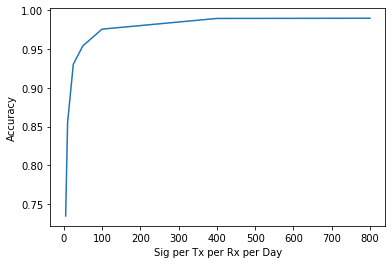

In [14]:
plt.plot(np.array(sig_len_list),smTest_results_real)
plt.xlabel('Sig per Tx per Rx per Day')
plt.ylabel('Accuracy')
print(sig_len_list)
print(smTest_results_real)

[5, 10, 25, 50, 100, 400, 800]
[0.7346527777777778, 0.8551736111111111, 0.9304861111111111, 0.9542013888888888, 0.9757638888888889, 0.9895486111111111, 0.9898263888888889]


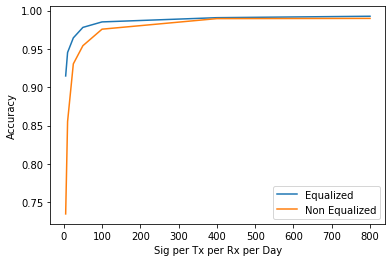

In [16]:
res_eq= [0.9147222222222222, 0.9453472222222222, 0.9644097222222222, 0.9780902777777778, 0.9852430555555556, 0.9907638888888889, 0.9926388888888888]
plt.plot(np.array(sig_len_list),res_eq)
plt.plot(np.array(sig_len_list),smTest_results_real)
plt.xlabel('Sig per Tx per Rx per Day')
plt.ylabel('Accuracy')
print(sig_len_list)
print(smTest_results_real)
plt.legend(['Equalized','Non Equalized'])